In [1]:
import pandas as pd
import glob
import os
import datetime
# import pvlib
from pv_model import model_pv_power
from forecast_solar import get_solar_forecast_fast
import matplotlib.pyplot as plt
# import scipy
import numpy as np

Read in specs that were processed and aggregated in the last notebook

In [2]:
folder = 'output_specs' 
filename = 'agg_specs_orig_df.pkl'
file_to_read = os.path.join(folder, filename)
agg_specs_orig_df = pd.read_pickle(file_to_read)
agg_specs_orig_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
latitude,32.811041,31.719983,33.021601,31.888,31.255,33.404486,30.4214,28.883196,31.435932,31.030996,32.104125,33.467803,32.4744,32.460054,32.533273,34.380532,26.090103,33.261505,29.271667,29.242304
longitude,-99.91749,-104.442292,-99.61463,-100.825,-102.272,-96.082472,-97.4614,-99.178605,-99.796613,-102.488209,-100.162375,-95.370856,-95.7156,-102.672809,-96.428985,-100.099625,-97.798453,-97.238057,-98.444722,-95.658144
nameplate_dc,131.5944,256.362179,94.507156,130.434783,234.0,170.854369,186.0,176.0,319.0,172.362353,143.08,260.0,82.098305,133.931,182.009816,165.306333,184.861111,191.275636,53.936118,162.4
nameplate_ac,100.8,188.2,74.9,100.0,180.0,125.7,144.0,132.4,250.0,126.3,102.2,198.5,59.8,100.7,147.6,121.4,137.5,148.8,39.2,120.0
mount_type,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis


In [3]:
num_plants = len(agg_specs_orig_df)
num_plants

20

Get a list of the timeseries files:

In [4]:
# timeseries data files
folder_ts = 'output_timeseries' 
filelist_ts = glob.glob(os.path.join(folder_ts, '*_actual_power_20240310-20250316.csv'))

Loop through plants and read in timeseries data:

In [5]:
agg_hsl = {}
agg_tel_net_out = {}

for plant_number in range(num_plants):
    # read in timeseries data from ERCOT
    ts_file = filelist_ts[plant_number]
    df_ts = pd.read_csv(ts_file,index_col=0,parse_dates=True,low_memory=False) #low_memory=False to avoid mixed variable type warning
    
    # outputs
    agg_hsl[plant_number] = df_ts['hsl']
    agg_tel_net_out[plant_number] = df_ts['telemetered_net_output']

# make dataframes 
agg_hsl_df = pd.concat(agg_hsl, axis=1)
agg_tel_net_out_df = pd.concat(agg_tel_net_out, axis=1)

In [6]:
thresh = 0.02 # fraction of peak power to set the curtailment threshold at
power_obs = agg_tel_net_out_df.resample('1h').mean()
hsl = agg_hsl_df.resample('1h').mean()
power_max_obs = power_obs.max()
curtailment = hsl - power_obs
curtailment_filter = curtailment > (thresh * power_max_obs)
# curtailment.iloc[:,0].plot()

In [7]:
power_obs[curtailment_filter] = np.nan

Let's import our ensemble forecast resource data:

In [8]:
# resource_data_ens = pd.read_csv('forecasts/resource_data_ens_20240310-20240616.csv', parse_dates=['valid_time', 'init_time'], index_col='valid_time')
# resource_data_ens = pd.read_csv('forecasts/resource_data_ens_20240310-20240310.csv', parse_dates=['valid_time', 'init_time'], index_col='valid_time')
resource_data_ens = pd.read_csv('forecasts/resource_data_ens_20240310-20250302.csv', parse_dates=['valid_time', 'init_time'], index_col='valid_time')

In [9]:
resource_data_ens.head()

,init_time,ghi_csi,ghi,dni,dhi,ghi_clear,member,point,temp_air,wind_speed,albedo
valid_time,,,,,,,,,,,
2024-03-11 12:30:00+00:00,2024-03-10 12:00:00,0.928330,0.000000,0.000000,0.000000,0.000000,1,0,7.621001,2,0.2
2024-03-11 13:30:00+00:00,2024-03-10 12:00:00,0.928330,72.504496,156.945061,54.387953,78.102100,1,0,9.051828,2,0.2
2024-03-11 14:30:00+00:00,2024-03-10 12:00:00,0.928330,276.400493,506.854800,111.988382,297.739588,1,0,10.482655,2,0.2
2024-03-11 15:30:00+00:00,2024-03-10 12:00:00,1.016201,506.267942,778.527934,109.962433,498.196465,1,0,12.317902,2,0.2
2024-03-11 16:30:00+00:00,2024-03-10 12:00:00,1.016201,670.212579,821.268263,130.759493,659.527318,1,0,14.571279,2,0.2


In [10]:
member_list = resource_data_ens['member'].unique()
point_list = resource_data_ens['point'].unique()

In [11]:
member_list

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

Now, let's model power using the resource forecasts to get power forecasts:

In [12]:
# empty lists
ens_temp_list = []

for member in member_list:
    for plant_number in point_list:
        # pull plant data
        plant_data = agg_specs_orig_df[plant_number].to_dict()

        # get the resource forecast for the plant
        resource_fcast_ens = resource_data_ens[(resource_data_ens['point']==plant_number) \
            & (resource_data_ens['member']==member)]
        
        resource_fcast_ens = resource_fcast_ens.reset_index().set_index('valid_time')

        # model power
        power_fcasts_ens, _ = model_pv_power(resource_fcast_ens, **plant_data)

        power_fcasts_ens.name = 'power'

        # convert to dataframe and add 'point' (plant number)
        power_fcasts_ens = power_fcasts_ens.to_frame()
        power_fcasts_ens['point'] = plant_number
        power_fcasts_ens['member'] = member

        ens_temp_list.append(power_fcasts_ens)

power_fcasts_ens_all = pd.concat(ens_temp_list)

pvlib.bifacial.infinite_sheds does not currently accept the perez-driesse model.
using haydavies instead.
pvlib.bifacial.infinite_sheds does not currently accept the perez-driesse model.
using haydavies instead.
pvlib.bifacial.infinite_sheds does not currently accept the perez-driesse model.
using haydavies instead.
pvlib.bifacial.infinite_sheds does not currently accept the perez-driesse model.
using haydavies instead.
pvlib.bifacial.infinite_sheds does not currently accept the perez-driesse model.
using haydavies instead.
pvlib.bifacial.infinite_sheds does not currently accept the perez-driesse model.
using haydavies instead.
pvlib.bifacial.infinite_sheds does not currently accept the perez-driesse model.
using haydavies instead.
pvlib.bifacial.infinite_sheds does not currently accept the perez-driesse model.
using haydavies instead.
pvlib.bifacial.infinite_sheds does not currently accept the perez-driesse model.
using haydavies instead.
pvlib.bifacial.infinite_sheds does not current

In [13]:
# adjust timestamps to beginning of interval to match observations
power_fcasts_ens_all.index = power_fcasts_ens_all.index - pd.Timedelta('30min')

In [14]:
power_fcasts_ens_all.head()

,power,point,member
valid_time,,,
2024-03-11 12:00:00+00:00,0.000000,0,1
2024-03-11 13:00:00+00:00,13.066049,0,1
2024-03-11 14:00:00+00:00,70.517710,0,1
2024-03-11 15:00:00+00:00,92.819363,0,1
2024-03-11 16:00:00+00:00,91.857386,0,1


In [15]:
power_obs_all = (hsl
                 .stack(future_stack=True)
                 .to_frame()
                 .reset_index()
                 .rename(columns={'interval_start_utc': 'valid_time',
                                  'level_1': 'point',
                                  0: 'power_obs'})
                 .set_index(['valid_time']))

power_obs_all

,point,power_obs
valid_time,,
2024-03-10 12:00:00+00:00,0,0.0
2024-03-10 12:00:00+00:00,1,0.0
2024-03-10 12:00:00+00:00,2,0.0
2024-03-10 12:00:00+00:00,3,0.0
2024-03-10 12:00:00+00:00,4,0.0
...,...,...
2025-03-16 11:00:00+00:00,15,0.0
2025-03-16 11:00:00+00:00,16,0.0
2025-03-16 11:00:00+00:00,17,0.0


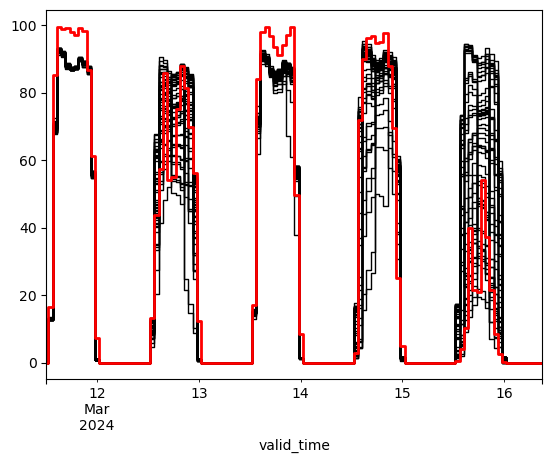

In [16]:
# for member in range(1, num_members+1):
# for plant_number in range(num_plants):
startidx=0
endidx=118

for plant_number in [0]:
    for member in member_list:
        power_fcasts_ens_all[(power_fcasts_ens_all['member'] == member) & (power_fcasts_ens_all['point'] == plant_number)]['power'][startidx:endidx].plot(label=('ens mem ' + str(member)), drawstyle='steps-mid', color='k', linewidth=1)
    power_obs_all[power_obs_all['point'] == plant_number]['power_obs'][startidx+24:endidx+24].plot(label=('ens mem ' + str(member)), drawstyle='steps-mid', color='r', linewidth=2)

Add week number, then add `week`, `point`, and `member` as indices.

In [17]:
df = power_fcasts_ens_all.copy()
# convert to central time

df.index = power_fcasts_ens_all.index.tz_convert('Etc/GMT+5')

# add week as a column
day_one = df.index.get_level_values('valid_time').min().floor('1d')

df['week'] = np.floor((df.index.get_level_values('valid_time') - day_one).days / 7)


df = df.reset_index().set_index(['week', 'point', 'member', 'valid_time'])
df

power
week point member valid_time                          
0.0  0     1      2024-03-11 07:00:00-05:00   0.000000
                  2024-03-11 08:00:00-05:00  13.066049
                  2024-03-11 09:00:00-05:00  70.517710
                  2024-03-11 10:00:00-05:00  92.819363
                  2024-03-11 11:00:00-05:00  91.857386
...                                                ...
52.0 19    50     2025-03-10 02:00:00-05:00   0.000000
                  2025-03-10 03:00:00-05:00   0.000000
                  2025-03-10 04:00:00-05:00   0.000000
                  2025-03-10 05:00:00-05:00   0.000000
                  2025-03-10 06:00:00-05:00   0.000000

[8724000 rows x 1 columns]

Use `groupby` to sum daily energy for each point and member:

In [18]:
df = df.groupby([pd.Grouper(level='point'),
                 pd.Grouper(level='week'),
                 pd.Grouper(level='member'), 
                 pd.Grouper(level='valid_time', freq='1D')]
               ).sum()
df = df.rename(columns={'power': 'daily_energy'})
df

daily_energy
point week member valid_time                             
0     0.0  1      2024-03-11 00:00:00-05:00    854.334573
                  2024-03-12 00:00:00-05:00    707.296945
                  2024-03-13 00:00:00-05:00    852.025870
                  2024-03-14 00:00:00-05:00    881.609321
                  2024-03-15 00:00:00-05:00    528.411331
...                                                   ...
19    52.0 46     2025-03-10 00:00:00-05:00      0.000000
           47     2025-03-10 00:00:00-05:00      0.000000
           48     2025-03-10 00:00:00-05:00      0.000000
           49     2025-03-10 00:00:00-05:00      0.000000
           50     2025-03-10 00:00:00-05:00      0.000000

[365000 rows x 1 columns]

Then, for each day in the week, calculate the number of members for which that day had the lowest daily energy.

First, just to make testing easier, filter on point 1 and members 1-4:

In [19]:
df_temp = df[(df.index.get_level_values('point')==0) & (df.index.get_level_values('member')<5)]

Then, unstack across members:

In [20]:
df_temp = df_temp.unstack(level='member')
df_temp

daily_energy                          \
member                                          1           2           3   
point week valid_time                                                       
0     0.0  2024-03-11 00:00:00-05:00   854.334573  848.223232  851.443964   
           2024-03-12 00:00:00-05:00   707.296945  506.756719  703.193134   
           2024-03-13 00:00:00-05:00   852.025870  838.997162  850.435061   
           2024-03-14 00:00:00-05:00   881.609321  767.570992  864.407213   
           2024-03-15 00:00:00-05:00   528.411331  271.040579  382.642551   
...                                           ...         ...         ...   
      51.0 2025-03-06 00:00:00-05:00   762.276809  608.425291  626.191539   
           2025-03-07 00:00:00-05:00   818.991984  833.340031  829.920140   
           2025-03-08 00:00:00-05:00   242.325951  909.729843  230.521084   
           2025-03-09 00:00:00-05:00   487.923879  905.284865  885.193203   
      52.0 2025-03-10 00:00:00-05:00     0.000000    0.000000    0.000000   

                                                  
member                                         4  
point week valid_time                             
0     0.0  2024-03-11 00:00:00-05:00  854.126575  
           2024-03-12 00:00:00-05:00  641.493112  
           2024-03-13 00:00:00-05:00  844.185788  
           2024-03-14 00:00:00-05:00  857.236553  
           2024-03-15 00:00:00-05:00  669.874081  
...                                          ...  
      51.0 2025-03-06 00:00:00-05:00  755.924256  
           2025-03-07 00:00:00-05:00  789.818843  
           2025-03-08 00:00:00-05:00  300.926574  
           2025-03-09 00:00:00-05:00  891.014866  
      52.0 2025-03-10 00:00:00-05:00    0.000000  

[365 rows x 4 columns]

We can group by point and week and find the minimum daily energy each week/point combination across members:

In [21]:
df_temp.groupby(level=['point','week']).min()

daily_energy                                    
member                1           2           3           4
point week                                                 
0     0.0    528.411331  268.590962  356.542446  169.292843
      1.0    527.102405  640.180274  201.413300  325.391794
      2.0    648.277009  610.773590  714.957686  749.816338
      3.0    427.051355  285.442788  228.790438  431.840063
      4.0    208.521289  387.333578  353.140982  289.591040
      5.0    164.813386  152.168734  267.944591  272.445029
      6.0    356.110545  341.242648  397.349663  343.367903
      7.0    218.159355  702.536603  425.316126  670.584358
      8.0    484.254710  312.926060  284.312224  446.721884
      9.0    579.494554  215.041608  438.609968  469.241735
      10.0   639.025923  715.808890  730.448385  641.307933
      11.0   411.646023  116.133080  327.647320  352.381391
      12.0   969.283540  860.086179  677.815442  605.753639
      13.0   294.554943  247.677284  366.122815  407.718292
      14.0   877.261161  795.446472  116.343178  797.704296
      15.0   932.199269  837.447228  811.614446  902.021516
      16.0   931.364985  628.186913  859.886611  365.811020
      17.0   684.774977  783.999760  758.660540  763.686897
      18.0   673.390559  452.863320  712.499561  773.550804
      19.0   916.646717  776.391972  524.751910  394.001241
      20.0   914.230732  776.025767  916.108565  798.598140
      21.0   871.912790  845.142116  861.367233  833.762249
      22.0   841.919759  815.691003  854.006900  690.885433
      23.0   703.548433  844.526045  873.439707  827.001758
      24.0   721.681809  602.645342  565.341809  836.578997
      25.0   117.893686  157.115808  177.083230  177.478090
      26.0   790.617425  731.763941  734.346893  852.779887
      27.0   494.303578  678.554343  355.103105  743.766121
      28.0   678.730673  576.483864  389.213514  365.240012
      29.0   712.629627  775.304313  778.284058  783.848050
      30.0   650.183171  705.594547  707.347450  735.873366
      31.0   348.311805  191.062022  338.292292  371.265091
      32.0   627.200384  616.097188  604.025840  636.553533
      33.0    77.585510  298.422464  216.061550  225.248011
      34.0   183.293025  148.606008  127.138766   83.394681
      35.0   194.439802  325.365751  276.042716  481.098715
      36.0   516.571353  547.514369  522.325470  548.161868
      37.0   289.761748  122.725467  139.658382  123.963002
      38.0   125.033988  268.811136  223.608624  192.546061
      39.0   100.957919   67.062008  293.162996  247.759245
      40.0   246.957286   94.603258  133.191188  152.845086
      41.0   212.627135  334.295107  177.953279  252.724598
      42.0   455.785119  171.414420  383.972022  467.415928
      43.0   111.530621   75.284985   58.519367   56.935582
      44.0   371.312826  244.021140   76.433221  291.126711
      45.0   205.774742  235.893243  479.535307  593.201578
      46.0    63.442317  125.982892  100.996849  136.594469
      47.0    35.902472  597.446976  568.805082  597.072529
      48.0    57.535330   46.638614   70.419613   71.445660
      49.0    93.498601  469.568074  341.778604  263.819180
      50.0   260.028290  178.118398  689.147737  553.191625
      51.0   242.325951  608.425291  230.521084  300.926574
      52.0     0.000000    0.000000    0.000000    0.000000

This sort-of gets the day with the minimum daily energy for each week/point combination across members:

In [22]:
df_temp.groupby(level=['point','week']).idxmin()

daily_energy  \
member                                         1   
point week                                         
0     0.0    (0, 0.0, 2024-03-15 00:00:00-05:00)   
      1.0    (0, 1.0, 2024-03-24 00:00:00-05:00)   
      2.0    (0, 2.0, 2024-03-27 00:00:00-05:00)   
      3.0    (0, 3.0, 2024-04-01 00:00:00-05:00)   
      4.0    (0, 4.0, 2024-04-09 00:00:00-05:00)   
      5.0    (0, 5.0, 2024-04-20 00:00:00-05:00)   
      6.0    (0, 6.0, 2024-04-25 00:00:00-05:00)   
      7.0    (0, 7.0, 2024-05-03 00:00:00-05:00)   
      8.0    (0, 8.0, 2024-05-12 00:00:00-05:00)   
      9.0    (0, 9.0, 2024-05-16 00:00:00-05:00)   
      10.0  (0, 10.0, 2024-05-22 00:00:00-05:00)   
      11.0  (0, 11.0, 2024-05-29 00:00:00-05:00)   
      12.0  (0, 12.0, 2024-06-09 00:00:00-05:00)   
      13.0  (0, 13.0, 2024-06-10 00:00:00-05:00)   
      14.0  (0, 14.0, 2024-06-21 00:00:00-05:00)   
      15.0  (0, 15.0, 2024-06-26 00:00:00-05:00)   
      16.0  (0, 16.0, 2024-07-07 00:00:00-05:00)   
      17.0  (0, 17.0, 2024-07-13 00:00:00-05:00)   
      18.0  (0, 18.0, 2024-07-21 00:00:00-05:00)   
      19.0  (0, 19.0, 2024-07-27 00:00:00-05:00)   
      20.0  (0, 20.0, 2024-08-04 00:00:00-05:00)   
      21.0  (0, 21.0, 2024-08-09 00:00:00-05:00)   
      22.0  (0, 22.0, 2024-08-17 00:00:00-05:00)   
      23.0  (0, 23.0, 2024-08-21 00:00:00-05:00)   
      24.0  (0, 24.0, 2024-08-31 00:00:00-05:00)   
      25.0  (0, 25.0, 2024-09-03 00:00:00-05:00)   
      26.0  (0, 26.0, 2024-09-14 00:00:00-05:00)   
      27.0  (0, 27.0, 2024-09-18 00:00:00-05:00)   
      28.0  (0, 28.0, 2024-09-25 00:00:00-05:00)   
      29.0  (0, 29.0, 2024-10-04 00:00:00-05:00)   
      30.0  (0, 30.0, 2024-10-12 00:00:00-05:00)   
      31.0  (0, 31.0, 2024-10-19 00:00:00-05:00)   
      32.0  (0, 32.0, 2024-10-27 00:00:00-05:00)   
      33.0  (0, 33.0, 2024-11-03 00:00:00-05:00)   
      34.0  (0, 34.0, 2024-11-07 00:00:00-05:00)   
      35.0  (0, 35.0, 2024-11-17 00:00:00-05:00)   
      36.0  (0, 36.0, 2024-11-23 00:00:00-05:00)   
      37.0  (0, 37.0, 2024-12-01 00:00:00-05:00)   
      38.0  (0, 38.0, 2024-12-06 00:00:00-05:00)   
      39.0  (0, 39.0, 2024-12-14 00:00:00-05:00)   
      40.0  (0, 40.0, 2024-12-17 00:00:00-05:00)   
      41.0  (0, 41.0, 2024-12-26 00:00:00-05:00)   
      42.0  (0, 42.0, 2025-01-01 00:00:00-05:00)   
      43.0  (0, 43.0, 2025-01-09 00:00:00-05:00)   
      44.0  (0, 44.0, 2025-01-17 00:00:00-05:00)   
      45.0  (0, 45.0, 2025-01-26 00:00:00-05:00)   
      46.0  (0, 46.0, 2025-01-29 00:00:00-05:00)   
      47.0  (0, 47.0, 2025-02-09 00:00:00-05:00)   
      48.0  (0, 48.0, 2025-02-10 00:00:00-05:00)   
      49.0  (0, 49.0, 2025-02-21 00:00:00-05:00)   
      50.0  (0, 50.0, 2025-03-01 00:00:00-05:00)   
      51.0  (0, 51.0, 2025-03-08 00:00:00-05:00)   
      52.0  (0, 52.0, 2025-03-10 00:00:00-05:00)   

                                                  \
member                                         2   
point week                                         
0     0.0    (0, 0.0, 2024-03-16 00:00:00-05:00)   
      1.0    (0, 1.0, 2024-03-20 00:00:00-05:00)   
      2.0    (0, 2.0, 2024-03-31 00:00:00-05:00)   
      3.0    (0, 3.0, 2024-04-01 00:00:00-05:00)   
      4.0    (0, 4.0, 2024-04-09 00:00:00-05:00)   
      5.0    (0, 5.0, 2024-04-20 00:00:00-05:00)   
      6.0    (0, 6.0, 2024-04-25 00:00:00-05:00)   
      7.0    (0, 7.0, 2024-05-01 00:00:00-05:00)   
      8.0    (0, 8.0, 2024-05-10 00:00:00-05:00)   
      9.0    (0, 9.0, 2024-05-16 00:00:00-05:00)   
      10.0  (0, 10.0, 2024-05-22 00:00:00-05:00)   
      11.0  (0, 11.0, 2024-05-29 00:00:00-05:00)   
      12.0  (0, 12.0, 2024-06-05 00:00:00-05:00)   
      13.0  (0, 13.0, 2024-06-10 00:00:00-05:00)   
      14.0  (0, 14.0, 2024-06-20 00:00:00-05:00)   
      15.0  (0, 15.0, 2024-06-28 00:00:00-05:00)   
      16.0  (0, 16.0, 2024-07-05 00:00:00-05:00)   
      17.0  (0, 17.0, 2024-07-10 00:00:00-05:00)   
      18.0  (0, 18.0, 2024-07-2

We can stack that

In [23]:
df_temp.groupby(level=['point','week']).idxmin().stack(future_stack=True)

daily_energy
point week member                                      
0     0.0  1        (0, 0.0, 2024-03-15 00:00:00-05:00)
           2        (0, 0.0, 2024-03-16 00:00:00-05:00)
           3        (0, 0.0, 2024-03-16 00:00:00-05:00)
           4        (0, 0.0, 2024-03-16 00:00:00-05:00)
      1.0  1        (0, 1.0, 2024-03-24 00:00:00-05:00)
...                                                 ...
      51.0 4       (0, 51.0, 2025-03-08 00:00:00-05:00)
      52.0 1       (0, 52.0, 2025-03-10 00:00:00-05:00)
           2       (0, 52.0, 2025-03-10 00:00:00-05:00)
           3       (0, 52.0, 2025-03-10 00:00:00-05:00)
           4       (0, 52.0, 2025-03-10 00:00:00-05:00)

[212 rows x 1 columns]

In [24]:
df_new = (df
          .unstack(level='member')
          .groupby(level=['point','week'])
          .idxmin()
          .stack(future_stack=True)
          .reset_index())

df_new = pd.DataFrame(list(df_new['daily_energy']),
         columns=['point', 'week', 'lowest_energy_day'])



Then reset the index:

In [25]:
df_temp2 = df_temp.groupby(level=['point','week']).idxmin().stack(future_stack=True).reset_index()
df_temp2

,point,week,member,daily_energy
0,0,0.0,1,"(0, 0.0, 2024-03-15 00:00:00-05:00)"
1,0,0.0,2,"(0, 0.0, 2024-03-16 00:00:00-05:00)"
2,0,0.0,3,"(0, 0.0, 2024-03-16 00:00:00-05:00)"
3,0,0.0,4,"(0, 0.0, 2024-03-16 00:00:00-05:00)"
4,0,1.0,1,"(0, 1.0, 2024-03-24 00:00:00-05:00)"
...,...,...,...,...
207,0,51.0,4,"(0, 51.0, 2025-03-08 00:00:00-05:00)"
208,0,52.0,1,"(0, 52.0, 2025-03-10 00:00:00-05:00)"
209,0,52.0,2,"(0, 52.0, 2025-03-10 00:00:00-05:00)"
210,0,52.0,3,"(0, 52.0, 2025-03-10 00:00:00-05:00)"


The `daily_energy` column is a list of tuples, containing point, member, and day (with minimum energy). We can simply extract that column and turn it into a dataframe:

In [26]:
df_temp2['daily_energy']

0       (0, 0.0, 2024-03-15 00:00:00-05:00)
1       (0, 0.0, 2024-03-16 00:00:00-05:00)
2       (0, 0.0, 2024-03-16 00:00:00-05:00)
3       (0, 0.0, 2024-03-16 00:00:00-05:00)
4       (0, 1.0, 2024-03-24 00:00:00-05:00)
                       ...                 
207    (0, 51.0, 2025-03-08 00:00:00-05:00)
208    (0, 52.0, 2025-03-10 00:00:00-05:00)
209    (0, 52.0, 2025-03-10 00:00:00-05:00)
210    (0, 52.0, 2025-03-10 00:00:00-05:00)
211    (0, 52.0, 2025-03-10 00:00:00-05:00)
Name: daily_energy, Length: 212, dtype: object

In [27]:
df_temp3 = pd.DataFrame(list(df_temp2['daily_energy']), columns=['point', 'week', 'lowest_energy_day'])
df_temp3

,point,week,lowest_energy_day
0,0,0.0,2024-03-15 00:00:00-05:00
1,0,0.0,2024-03-16 00:00:00-05:00
2,0,0.0,2024-03-16 00:00:00-05:00
3,0,0.0,2024-03-16 00:00:00-05:00
4,0,1.0,2024-03-24 00:00:00-05:00
...,...,...,...
207,0,51.0,2025-03-08 00:00:00-05:00
208,0,52.0,2025-03-10 00:00:00-05:00
209,0,52.0,2025-03-10 00:00:00-05:00
210,0,52.0,2025-03-10 00:00:00-05:00


In [28]:
df_temp3.groupby(['week', 'point']).value_counts()

week  point  lowest_energy_day        
0.0   0      2024-03-16 00:00:00-05:00    3
             2024-03-15 00:00:00-05:00    1
1.0   0      2024-03-24 00:00:00-05:00    3
             2024-03-20 00:00:00-05:00    1
2.0   0      2024-03-31 00:00:00-05:00    2
                                         ..
50.0  0      2025-02-26 00:00:00-05:00    1
             2025-03-01 00:00:00-05:00    1
51.0  0      2025-03-08 00:00:00-05:00    3
             2025-03-06 00:00:00-05:00    1
52.0  0      2025-03-10 00:00:00-05:00    4
Name: count, Length: 124, dtype: int64

Looks good. Repeat for the full dataset:

In [29]:
# unstack, group by point and week, find min index, re-stack, reset index
df_fcast = (df
		.unstack(level='member')
		.groupby(level=['point','week'])
		.idxmin()
		.stack(future_stack=True)
		.reset_index())


# The `daily_energy` column is a list of tuples, containing point, member,
# and day (with minimum energy). We can simply extract that column and turn
# it into a dataframe
df_fcast = pd.DataFrame(list(df_fcast['daily_energy']),
		columns=['point', 'week', 'valid_time'])

# then get value_counts()
# from https://note.nkmk.me/en/python-pandas-value-counts/
df_fcast = df_fcast.groupby(['week', 'point']).value_counts(dropna=False).to_frame()

df_fcast = df_fcast.rename(columns={'count': 'lowest_day_count'})

df_fcast

lowest_day_count
week point valid_time                                 
0.0  0     2024-03-15 00:00:00-05:00                18
           2024-03-16 00:00:00-05:00                18
           2024-03-17 00:00:00-05:00                11
           2024-03-14 00:00:00-05:00                 2
           2024-03-12 00:00:00-05:00                 1
...                                                ...
52.0 15    2025-03-10 00:00:00-05:00                50
     16    2025-03-10 00:00:00-05:00                50
     17    2025-03-10 00:00:00-05:00                50
     18    2025-03-10 00:00:00-05:00                50
     19    2025-03-10 00:00:00-05:00                50

[5067 rows x 1 columns]

TODO:
- Turn observation dataframe into multiindex with week, point, day, and daily energy.
- Merge with df_new, matching week:week, point:point, day:lowest_energy_day
- loop through plants (point) and weeks
  - for each point-week:
   - calculate weekly energy with with optimal day dropped
   - calculate weekly energy with best forecast day droppped
     - [new] calculate "confidence" in that day (count?)
   - calculate weekly energy with all possible random days dropped


In [ ]:
df_obs = power_obs_all.copy()
# convert to central time
df_obs.index = power_obs_all.index.tz_convert('Etc/GMT+5')

# trim to times we have forecasts
start = power_fcasts_ens_all.index[0]
end = power_fcasts_ens_all.index[-1]
df_obs = df_obs[(df_obs.index >= start) & (df_obs.index < end)]

# add week as a column
day_one = df_obs.index.min().floor('1d')
df_obs['week'] = np.floor((df_obs.copy().index - day_one).days / 7)

# make multiindex
df_obs = df_obs.reset_index().set_index(['week', 'point', 'valid_time'])

# resample to daily sum
df_obs = df_obs.groupby([pd.Grouper(level='point'),
                 pd.Grouper(level='week'),
                 pd.Grouper(level='valid_time', freq='1D')]
               ).sum()

# rename column
df_obs = df_obs.rename(columns={'power_obs': 'daily_obs_energy'})

# preview
df_obs

daily_obs_energy
point week valid_time                                 
0     0.0  2024-03-11 00:00:00-05:00           946.925
           2024-03-12 00:00:00-05:00           691.850
           2024-03-13 00:00:00-05:00           928.175
           2024-03-14 00:00:00-05:00           832.300
           2024-03-15 00:00:00-05:00           221.200
...                                                ...
19    51.0 2025-03-05 00:00:00-05:00          1008.850
           2025-03-06 00:00:00-05:00          1015.650
           2025-03-07 00:00:00-05:00           383.300
           2025-03-08 00:00:00-05:00           469.225
           2025-03-09 00:00:00-05:00           549.250

[7280 rows x 1 columns]

In [85]:
# merge forecasts and observations
df = df_obs.merge(df_fcast, how='outer', left_index=True, right_index=True)
df = df.reset_index().set_index('valid_time')
df

,point,week,daily_obs_energy,lowest_day_count
valid_time,,,,
2024-03-11 00:00:00-05:00,0,0.0,946.925,NaN
2024-03-12 00:00:00-05:00,0,0.0,691.850,1.0
2024-03-13 00:00:00-05:00,0,0.0,928.175,NaN
2024-03-14 00:00:00-05:00,0,0.0,832.300,2.0
2024-03-15 00:00:00-05:00,0,0.0,221.200,18.0
...,...,...,...,...
2025-03-06 00:00:00-05:00,19,51.0,1015.650,NaN
2025-03-07 00:00:00-05:00,19,51.0,383.300,8.0
2025-03-08 00:00:00-05:00,19,51.0,469.225,15.0


*Note: our forecasts end on `2025-03-10`, a Monday, and we need it to end on a Sunday, so we will trim the dataframe.*

In [86]:
last_day = '2025-03-10'
df = df[df.index < last_day]

Now, calculate weekly energy values similar to the last analysis. But, we will not vary the number of days out, and will just stick with 7 days, becuase the previous steps only apply to 7 day (week) windows.

Because it's possible to have a tie for the day that was most often forecasted with the lowest daily energy, we will select the first (this happens to be hour `.argmax()` works anyway).

In [87]:
df['week'].unique()[0]

np.float64(0.0)

In [102]:
num_days = 5
i=0
week = df['week'].unique()[0]
df_daily_temp = df[(df['point']==i) & (df['week']==week)]
df_daily_temp

,point,week,daily_obs_energy,lowest_day_count
valid_time,,,,
2024-03-11 00:00:00-05:00,0,0.0,946.925,NaN
2024-03-12 00:00:00-05:00,0,0.0,691.850,1.0
2024-03-13 00:00:00-05:00,0,0.0,928.175,NaN
2024-03-14 00:00:00-05:00,0,0.0,832.300,2.0
2024-03-15 00:00:00-05:00,0,0.0,221.200,18.0
2024-03-16 00:00:00-05:00,0,0.0,57.225,18.0
2024-03-17 00:00:00-05:00,0,0.0,144.650,11.0


In [103]:
df[(df['point']==i) & (df['week']==week)]

,point,week,daily_obs_energy,lowest_day_count
valid_time,,,,
2024-03-11 00:00:00-05:00,0,0.0,946.925,NaN
2024-03-12 00:00:00-05:00,0,0.0,691.850,1.0
2024-03-13 00:00:00-05:00,0,0.0,928.175,NaN
2024-03-14 00:00:00-05:00,0,0.0,832.300,2.0
2024-03-15 00:00:00-05:00,0,0.0,221.200,18.0
2024-03-16 00:00:00-05:00,0,0.0,57.225,18.0
2024-03-17 00:00:00-05:00,0,0.0,144.650,11.0


In [104]:
drop_day_number = df_daily_temp['daily_obs_energy'].argmin()
df_daily_temp.drop(df_daily_temp.index[drop_day_number])['daily_obs_energy'].sum()

np.float64(3765.1)

In [105]:
drop_day_number = df_daily_temp['lowest_day_count'].argmax()
df_daily_temp.drop(df_daily_temp.index[drop_day_number])['daily_obs_energy'].sum()

np.float64(3601.125)

In [136]:
num_weeks = df['week'].unique().max()
range(int(num_weeks))

range(0, 51)

...

In [233]:
num_days = 7 # don't change this
num_members = len(power_fcasts_ens_all['member'].unique())
num_weeks = int(df['week'].unique().max())

weekly_optimal = {}
weekly_fcast_ifs_ens = {}
weekly_fcast_confidence = {}
weekly_rand = {}
weekly_rand_avg = {}
weekly_rel_loss_reduction = {}
weekly_abs_loss_reduction = {}
rel_loss_reductions_ifs_ens = {}
for i in range(num_plants):
    weekly_energy_optimal_list = []
    weekly_energy_fcast_ifs_ens_list = []
    weekly_fcast_conf_list = []
    weekly_energy_random_list = []
    weekly_energy_random_avg_list = []
    weekly_rel_loss_red_list = []
    weekly_abs_loss_red_list = []
    for week in range(num_weeks):
        # dataframe filtered to plant and week of interest
        df_daily_temp = df[(df['point']==i) & (df['week']==week)]
        # weekly energy with optimal outage scheduling
        drop_day_number = df_daily_temp['daily_obs_energy'].argmin()
        we_opt = df_daily_temp.drop(df_daily_temp.index[drop_day_number])['daily_obs_energy'].sum()

        # weekly energy with forecast-based outage scheduling
        drop_day_number = df_daily_temp['lowest_day_count'].argmax()
        we_fcast_ifs_ens = df_daily_temp.drop(df_daily_temp.index[drop_day_number])['daily_obs_energy'].sum()
        we_conf = df_daily_temp['lowest_day_count'].iloc[drop_day_number]/num_members

        # weekly energy with all possible random days
        temp = []
        for j in range(num_days):
            we_rand = df_daily_temp.drop(df_daily_temp.index[j])['daily_obs_energy'].sum()
            temp.append(we_rand)
        
        # weekly loss reduction
        loss_fcast_ifs = (we_opt - we_fcast_ifs_ens) / we_opt
        loss_rand = (we_opt - np.mean(temp)) / we_opt
        weekly_rel_loss_red = 1-loss_fcast_ifs/loss_rand
        weekly_abs_loss_red = we_fcast_ifs_ens - np.mean(temp)
        # normalize absolute loss reduction by plant ac nameplate
        weekly_abs_loss_red = weekly_abs_loss_red/agg_specs_orig_df[i]['nameplate_ac']

        weekly_rel_loss_red_list.append(weekly_rel_loss_red)
        weekly_abs_loss_red_list.append(weekly_abs_loss_red)
        weekly_energy_random_list.append(temp)
        weekly_energy_random_avg_list.append(np.mean(temp))

        weekly_energy_optimal_list.append(we_opt)
        weekly_energy_fcast_ifs_ens_list.append(we_fcast_ifs_ens)
        weekly_fcast_conf_list.append(we_conf)

    weekly_optimal[i] = weekly_energy_optimal_list
    weekly_fcast_ifs_ens[i] = weekly_energy_fcast_ifs_ens_list
    weekly_rand[i] = weekly_energy_random_list
    weekly_rand_avg[i]= weekly_energy_random_avg_list
    weekly_fcast_confidence[i] = weekly_fcast_conf_list
    weekly_rel_loss_reduction[i] = weekly_rel_loss_red_list
    weekly_abs_loss_reduction[i] = weekly_abs_loss_red_list

    E_opt = np.sum(weekly_optimal[i])
    E_fcast_ifs_ens = np.sum(weekly_fcast_ifs_ens[i])
    E_r_mean = np.mean(np.sum(weekly_rand[i], axis=0))
    E_r_max = np.max(np.sum(weekly_rand[i], axis=0))
    E_r_min = np.min(np.sum(weekly_rand[i], axis=0))

    loss_fcast_ifs = (E_opt - E_fcast_ifs_ens)/E_opt
    loss_rand = (E_opt - E_r_mean)/E_opt

    rel_loss_reduction_ifs = 1-loss_fcast_ifs/loss_rand
    rel_loss_reductions_ifs_ens[i] = rel_loss_reduction_ifs

C:\Users\willh\AppData\Local\Temp\ipykernel_69012\3242465845.py:40: RuntimeWarning: invalid value encountered in scalar divide
  loss_fcast_ifs = (we_opt - we_fcast_ifs_ens) / we_opt
C:\Users\willh\AppData\Local\Temp\ipykernel_69012\3242465845.py:41: RuntimeWarning: invalid value encountered in scalar divide
  loss_rand = (we_opt - np.mean(temp)) / we_opt
C:\Users\willh\AppData\Local\Temp\ipykernel_69012\3242465845.py:40: RuntimeWarning: invalid value encountered in scalar divide
  loss_fcast_ifs = (we_opt - we_fcast_ifs_ens) / we_opt
C:\Users\willh\AppData\Local\Temp\ipykernel_69012\3242465845.py:41: RuntimeWarning: invalid value encountered in scalar divide
  loss_rand = (we_opt - np.mean(temp)) / we_opt
C:\Users\willh\AppData\Local\Temp\ipykernel_69012\3242465845.py:40: RuntimeWarning: invalid value encountered in scalar divide
  loss_fcast_ifs = (we_opt - we_fcast_ifs_ens) / we_opt
C:\Users\willh\AppData\Local\Temp\ipykernel_69012\3242465845.py:41: RuntimeWarning: invalid value enc

Plot for a single plant:

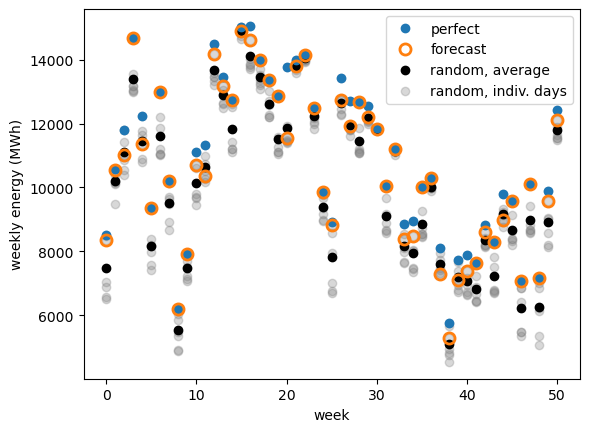

In [205]:
i = 8
# plot random first so it's in the back
plt.plot(weekly_rand[i],'o',ls='None', alpha=0.3, color='gray', label='random, indiv. days')
plt.plot(weekly_rand_avg[i],'o',ls='None', color='k', label='random, average')
plt.plot(weekly_optimal[i],'o',ls='None', label = 'perfect')
plt.plot(weekly_fcast_ifs_ens[i],'o',ms=8,fillstyle='none',markeredgewidth=2,ls='None', label = 'forecast')

plt.ylabel('weekly energy (MWh)')
plt.xlabel('week')

# custom order for legend, since random was plotted first
handles,labels = plt.gca().get_legend_handles_labels()
handles = [handles[-2], handles[-1], handles[-3], handles[0]]
labels = [labels[-2], labels[-1], labels[-3], labels[0]]
plt.legend(handles,labels)
# plt.savefig('images/weekly_energy_selection.png', dpi=400, bbox_inches='tight')
plt.show()

In [273]:
# dataframe with index of [week, point] and column of weekly_fcast_confidence, 
# weekly_rel_loss_reduction, weekly_abs_loss_reduction
df_weekly_stats = pd.concat([pd.DataFrame(weekly_fcast_confidence).stack(),
                             pd.DataFrame(weekly_rel_loss_reduction).stack(),
                             pd.DataFrame(weekly_abs_loss_reduction).stack()], axis=1)
df_weekly_stats
# df_weekly_stats.rename(columns={'0','weekly_fcast_confidence'})

0         1         2
0  0   0.36  0.664550  3.222683
   1   0.48  0.450875  2.060441
   2   0.34  0.600498  2.772935
   3   0.44  0.957131  4.465429
   4   0.38  1.000000  3.655794
...     ...       ...       ...
50 15  0.66  1.000000  5.372205
   16  0.42  0.560238  1.986675
   17  0.66  0.160961  0.744960
   18  0.56 -0.034657 -0.102861
   19  0.62  0.795909  1.225179

[1020 rows x 3 columns]

In [280]:
df_weekly_stats.columns = ['weekly_fcast_confidence', 'weekly_rel_loss_reduction', 'weekly_abs_loss_reduction']
df_weekly_stats = df_weekly_stats.rename_axis(index=['week', 'point'])
df_weekly_stats

weekly_fcast_confidence  weekly_rel_loss_reduction  \
week point                                                       
0    0                         0.36                   0.664550   
     1                         0.48                   0.450875   
     2                         0.34                   0.600498   
     3                         0.44                   0.957131   
     4                         0.38                   1.000000   
...                             ...                        ...   
50   15                        0.66                   1.000000   
     16                        0.42                   0.560238   
     17                        0.66                   0.160961   
     18                        0.56                  -0.034657   
     19                        0.62                   0.795909   

            weekly_abs_loss_reduction  
week point                             
0    0                       3.222683  
     1                       2.060441  
     2                       2.772935  
     3                       4.465429  
     4                       3.655794  
...                               ...  
50   15                      5.372205  
     16                      1.986675  
     17                      0.744960  
     18                     -0.102861  
     19                      1.225179  

[1020 rows x 3 columns]

Text(0.5, 0, 'Forecast "Confidence"')

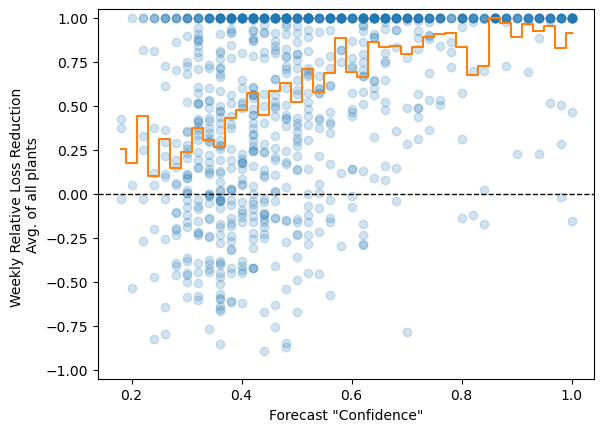

In [281]:
plt.scatter(df_weekly_stats['weekly_fcast_confidence'],
            df_weekly_stats['weekly_rel_loss_reduction'],
            alpha=0.2)
plt.plot(df_weekly_stats.groupby(['weekly_fcast_confidence']).mean().index,
         df_weekly_stats.groupby(['weekly_fcast_confidence']).mean()['weekly_rel_loss_reduction'].values,
         color='C1',
         drawstyle='steps-mid')
plt.ylim([-1.05,1.05])
# plt.xlim([0,1])
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.ylabel('Weekly Relative Loss Reduction \nAvg. of all plants')
plt.xlabel('Forecast "Confidence"')

Text(0.5, 0, 'Forecast "Confidence"')

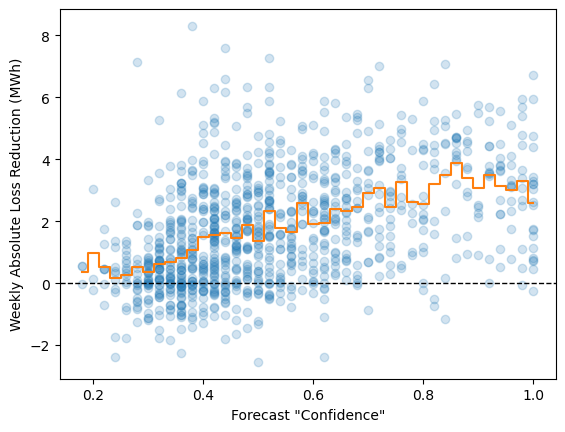

In [282]:
plt.scatter(df_weekly_stats['weekly_fcast_confidence'],
            df_weekly_stats['weekly_abs_loss_reduction'],
            alpha=0.2)
plt.plot(df_weekly_stats.groupby(['weekly_fcast_confidence']).mean().index,
         df_weekly_stats.groupby(['weekly_fcast_confidence']).mean()['weekly_abs_loss_reduction'].values,
         color='C1',
         drawstyle='steps-mid')

plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.ylabel('Weekly Absolute Loss Reduction (MWh)')
plt.xlabel('Forecast "Confidence"')

In [269]:
# import cartopy
import cartopy.crs as crs
import cartopy.feature as cfeature

In [270]:
rel_loss_reductions_ifs_ens.values()

dict_values([np.float64(0.7706587968703831), np.float64(0.5720642437896595), np.float64(0.7180561899026336), np.float64(0.7176234225050475), np.float64(0.605233436916722), np.float64(0.6916581131139299), np.float64(0.6077772355794007), np.float64(0.5951647569960326), np.float64(0.6428236635813684), np.float64(0.515726777108852), np.float64(0.7180160725011124), np.float64(0.7318206817478505), np.float64(0.7424779892234482), np.float64(0.7187111443373189), np.float64(0.639321409049169), np.float64(0.7714081464914535), np.float64(0.5399665443424604), np.float64(0.7112104468563902), np.float64(0.5828445101933919), np.float64(0.5595679091639819)])

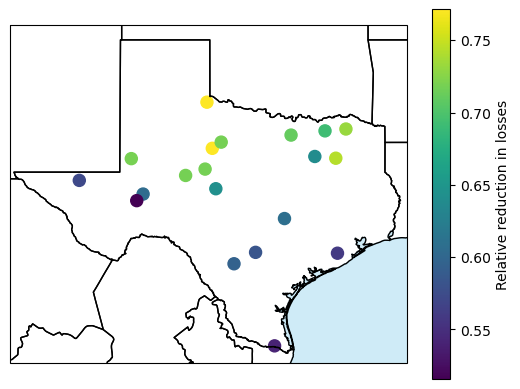

In [295]:
fig = plt.figure()

ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())

ax.add_feature(cfeature.OCEAN, color="skyblue", alpha=0.4)
ax.add_feature(cfeature.STATES)

ax.set_extent([-106.8, -93.3, 25.5, 37],
              crs=crs.PlateCarree()) ## Important

plt.scatter(agg_specs_orig_df.T['longitude'], agg_specs_orig_df.T['latitude'], s=75, c=rel_loss_reductions_ifs_ens.values())
plt.colorbar(label='Relative reduction in losses')
plt.show()

Let's look at the fraction of weeks where the forecast confidence is above a certain threshold for each plant:

In [290]:

thresh = 0.5
high_conf_weeks = df_weekly_stats.groupby('point')['weekly_fcast_confidence'].apply(lambda x: (x>thresh).sum()/len(x))
high_conf_weeks.values

array([0.49019608, 0.41176471, 0.47058824, 0.45098039, 0.45098039,
       0.49019608, 0.49019608, 0.29411765, 0.43137255, 0.45098039,
       0.43137255, 0.54901961, 0.47058824, 0.52941176, 0.52941176,
       0.54901961, 0.29411765, 0.52941176, 0.39215686, 0.25490196])

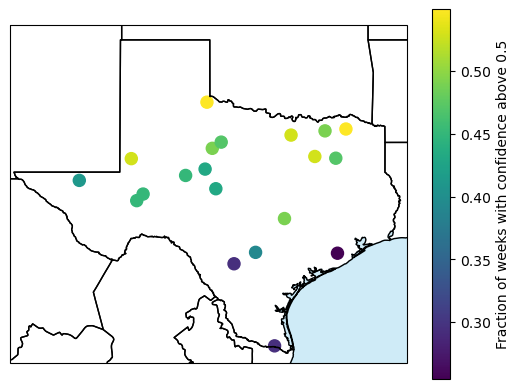

In [296]:
fig = plt.figure()

ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())

ax.add_feature(cfeature.OCEAN, color="skyblue", alpha=0.4)
ax.add_feature(cfeature.STATES)

ax.set_extent([-106.8, -93.3, 25.5, 37],
              crs=crs.PlateCarree()) ## Important

plt.scatter(agg_specs_orig_df.T['longitude'],
            agg_specs_orig_df.T['latitude'],
            s=75,
            c=high_conf_weeks.values)
plt.colorbar(label='Fraction of weeks with confidence above ' + str(thresh))
plt.show()

Calculate totals:

In [95]:
E_opt = np.sum(weekly_optimal[i])
E_fcast = np.sum(weekly_fcast_ifs_ens[i])
E_r_mean = np.mean(np.sum(weekly_rand[i], axis=0))
E_r_max = np.max(np.sum(weekly_rand[i], axis=0))
E_r_min = np.min(np.sum(weekly_rand[i], axis=0))

print('Total MWh with...')
print('perfect scheduling:  ', E_opt)
print('forecast scheduling: ', E_fcast)
print('random scheduling:   ', E_r_mean, ' (mean)')
print('random scheduling:   ', E_r_max, ' (best)')
print('random scheduling:   ', E_r_min, ' (worst)')

Total MWh with...
perfect scheduling:   564243.1416666667
forecast scheduling:  549688.9416666667
random scheduling:    524884.3642857143  (mean)
random scheduling:    528854.2166666667  (best)
random scheduling:    522057.1666666667  (worst)


And some relative differences:

In [96]:
print((E_opt - E_fcast)/E_opt)
print((E_opt - E_r_mean)/E_opt)

0.02579419921172588
0.06975499474339032


Loss reduction from the forecast vs random scheduling:

In [97]:
loss_fcast = (E_opt - E_fcast)/E_opt
loss_rand = (E_opt - E_r_mean)/E_opt

rel_loss_reduction = 1-loss_fcast/loss_rand

print(rel_loss_reduction)

0.6302171721664416


Bar chart:

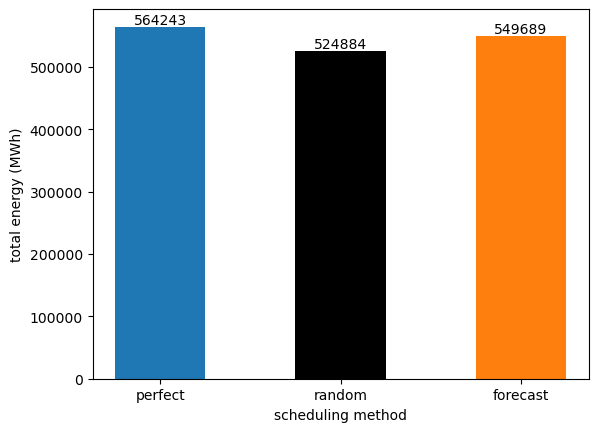

In [98]:
fig, ax = plt.subplots()
p = ax.bar(
    ['perfect', 'random', 'forecast'],
    [E_opt, E_r_mean, E_fcast],
    color = ['tab:blue','black','tab:orange'], width=0.5)
ax.bar_label(p, label_type='edge')
plt.ylabel('total energy (MWh)')
plt.xlabel('scheduling method')
# plt.savefig('images/total_energy_bar.png', dpi=400, bbox_inches='tight')
plt.show()

Now, let's loop through all the plants and types of forecasts (GFS, IFS, and the average power from the two).

In [ ]:
# intialize lists of dictionaries
rel_loss_reductions_gfs = [{} for i in range(num_plants)]
rel_loss_reductions_ifs = [{} for i in range(num_plants)]
rel_loss_reductions_mean = [{} for i in range(num_plants)]

# loop through scheduling horizons, 2 to 7 days out (one day doesn't give an option...)
for num_days in range(2,7+1):
    # initialize dictionaries
    weekly_optimal = {}
    weekly_fcast_gfs = {}
    weekly_fcast_ifs = {}
    weekly_fcast_mean = {}
    weekly_rand = {}
    weekly_rand_avg = {}
    for i in range(num_plants):
        # initialize lists
        weekly_energy_optimal_list = []
        weekly_energy_fcast_gfs_list = []
        weekly_energy_fcast_ifs_list = []
        weekly_energy_fcast_mean_list = []
        weekly_energy_random_list = []
        weekly_energy_random_avg_list = []
        for week in power_obs_and_fcast_daily[i]['week'].unique():
            # dataframe filtered to plant and week of interest
            df_daily_temp = power_obs_and_fcast_daily[i][power_obs_and_fcast_daily[i]['week']==week].iloc[:num_days]
            # weekly energy with optimal outage scheduling
            drop_day_number = df_daily_temp['power_obs'].argmin()
            we_opt = df_daily_temp.drop(df_daily_temp.index[drop_day_number])['power_obs'].sum()
            
            # weekly energy with forecast-based outage scheduling
            drop_day_number = df_daily_temp['power_fcast_gfs'].argmin()
            we_fcast_gfs = df_daily_temp.drop(df_daily_temp.index[drop_day_number])['power_obs'].sum()
            drop_day_number = df_daily_temp['power_fcast_ifs'].argmin()
            we_fcast_ifs = df_daily_temp.drop(df_daily_temp.index[drop_day_number])['power_obs'].sum()
            drop_day_number = df_daily_temp['power_fcast_mean'].argmin()
            we_fcast_mean = df_daily_temp.drop(df_daily_temp.index[drop_day_number])['power_obs'].sum()

            # weekly energy with all possible random days
            temp = []
            for j in range(num_days):
                we_rand = df_daily_temp.drop(df_daily_temp.index[j])['power_obs'].sum()
                temp.append(we_rand)
            weekly_energy_random_list.append(temp)
            weekly_energy_random_avg_list.append(np.mean(temp))

            weekly_energy_optimal_list.append(we_opt)
            weekly_energy_fcast_gfs_list.append(we_fcast_gfs)
            weekly_energy_fcast_ifs_list.append(we_fcast_ifs)
            weekly_energy_fcast_mean_list.append(we_fcast_mean)
        weekly_optimal[i] = weekly_energy_optimal_list
        weekly_fcast_gfs[i] = weekly_energy_fcast_gfs_list
        weekly_fcast_ifs[i] = weekly_energy_fcast_ifs_list
        weekly_fcast_mean[i] = weekly_energy_fcast_mean_list
        weekly_rand[i] = weekly_energy_random_list
        weekly_rand_avg[i]= weekly_energy_random_avg_list

        E_opt = np.sum(weekly_optimal[i])
        E_fcast_gfs = np.sum(weekly_fcast_gfs[i])
        E_fcast_ifs = np.sum(weekly_fcast_ifs[i])
        E_fcast_mean = np.sum(weekly_fcast_mean[i])
        E_r_mean = np.mean(np.sum(weekly_rand[i], axis=0))
        E_r_max = np.max(np.sum(weekly_rand[i], axis=0))
        E_r_min = np.min(np.sum(weekly_rand[i], axis=0))

        loss_fcast_gfs = (E_opt - E_fcast_gfs)/E_opt
        loss_fcast_ifs = (E_opt - E_fcast_ifs)/E_opt
        loss_fcast_mean = (E_opt - E_fcast_mean)/E_opt
        loss_rand = (E_opt - E_r_mean)/E_opt

        rel_loss_reduction_gfs = 1-loss_fcast_gfs/loss_rand
        rel_loss_reductions_gfs[i][num_days] = rel_loss_reduction_gfs

        rel_loss_reduction_ifs = 1-loss_fcast_ifs/loss_rand
        rel_loss_reductions_ifs[i][num_days] = rel_loss_reduction_ifs

        rel_loss_reduction_mean = 1-loss_fcast_mean/loss_rand
        rel_loss_reductions_mean[i][num_days] = rel_loss_reduction_mean

We can convert the list of dictionaries into a dataframe with plants as columns and days-ahead as rows:

In [ ]:
pd.DataFrame(rel_loss_reductions_gfs).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
2,0.720982,0.562602,0.812013,0.272412,0.743743,0.766786,0.732410,0.699306,0.446771,0.397683,0.670874,0.678750,0.496234,0.609543,0.632055,0.825823,0.411062,0.829491,0.642042,0.729096
3,0.706760,0.550409,0.597152,0.473086,0.833692,0.701156,0.772003,0.640021,0.554496,0.515689,0.669344,0.659571,0.586295,0.608309,0.693287,0.757796,0.512434,0.802563,0.650850,0.467158
4,0.675662,0.619246,0.659546,0.540998,0.768129,0.485929,0.605643,0.550025,0.527251,0.475104,0.546340,0.556222,0.632072,0.507317,0.663775,0.758254,0.419431,0.714568,0.596591,0.484441
5,0.591108,0.659063,0.585385,0.523366,0.659209,0.525254,0.529101,0.538784,0.684773,0.295323,0.517926,0.421587,0.508237,0.591488,0.597404,0.717176,0.545655,0.706514,0.617918,0.493595
6,0.644024,0.584103,0.671788,0.627847,0.728775,0.528298,0.545869,0.549996,0.697671,0.488868,0.592854,0.508259,0.499343,0.679163,0.573722,0.733272,0.561445,0.663968,0.543529,0.465944
7,0.653856,0.552634,0.670838,0.619870,0.694337,0.530922,0.445255,0.474047,0.682673,0.597452,0.577906,0.387837,0.485493,0.619312,0.505289,0.687090,0.629088,0.663032,0.495723,0.534806


And calculate the median across plants for each day-ahead:

In [ ]:
pd.DataFrame(rel_loss_reductions_gfs).T.mean(axis=1)

2    0.633984
3    0.637604
4    0.589327
5    0.565443
6    0.594437
7    0.575373
dtype: float64

And a plot:

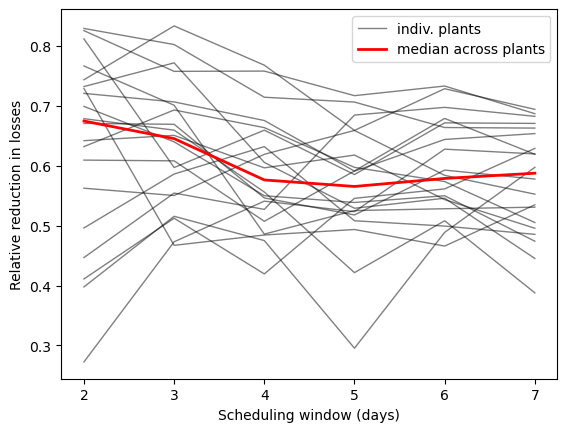

In [ ]:
pd.DataFrame(rel_loss_reductions_gfs).T.plot(color='black', linewidth=1, alpha=0.5, legend=False)
pd.DataFrame(rel_loss_reductions_gfs).T.median(axis=1).plot(color='red', linewidth=2, label='median across plants')
plt.ylabel('Relative reduction in losses')
plt.xlabel('Scheduling window (days)')

# custom legend
handles,labels = plt.gca().get_legend_handles_labels()
handles = [handles[-2], handles[-1]]
labels = ['indiv. plants', labels[-1]]
plt.legend(handles,labels)

# plt.legend()
plt.show()

And write resulting dataframes to CSV and pickle files.

In [ ]:
# start = resource_data_ens.reset_index()['init_time'].iloc[0].strftime('%Y%m%d')
# end = resource_data_ens.reset_index()['init_time'].iloc[-1].strftime('%Y%m%d')

# power_fcasts_ens_all.to_pickle('forecasts/power_fcasts_ens_all_' + start + '-' + end + '.pkl')
# power_fcasts_ens_all.to_csv('forecasts/power_fcasts_ens_all_' + start + '-' + end + '.csv')

In [ ]:
# power_fcasts_gfs_all = pd.read_csv('forecasts/power_fcasts_gfs_all.csv', parse_dates=['valid_time'], index_col='valid_time')
# power_fcasts_ifs_all = pd.read_csv('forecasts/power_fcasts_ifs_all.csv', parse_dates=['valid_time'], index_col='valid_time')